In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import seaborn as sns
import TsModel
import GprModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [29]:
exp31_results = {
    'gp_tsl_train_accuracy':gp_tsl_train_accuracy,
    'gp_tsl_test_accuracy':gp_tsl_test_accuracy,
    'gp_tsl_r2s':gp_tsl_r2s,
    'gp_tsl_time':gp_tsl_time,
    'gp_tsc_train_accuracy':gp_tsc_train_accuracy,
    'gp_tsc_test_accuracy':gp_tsc_test_accuracy,
    'gp_tsc_r2s':gp_tsc_r2s,
    'gp_tsc_time':gp_tsc_time,
    'gp_nn_tsl_train_accuracy':gp_nn_tsl_train_accuracy,
    'gp_nn_tsl_test_accuracy':gp_nn_tsl_test_accuracy,
    'gp_nn_tsl_r2s':gp_nn_tsl_r2s,
    'nn_tsl_r2s':nn_tsl_r2s,
    'gp_nn_tsl_time':gp_nn_tsl_time,
    'gp_nn_tsc_train_accuracy':gp_nn_tsc_train_accuracy,
    'gp_nn_tsc_test_accuracy':gp_nn_tsc_test_accuracy,
    'gp_nn_tsc_r2s':gp_nn_tsc_r2s,
    'nn_tsc_r2s':nn_tsc_r2s,
    'gp_nn_tsc_time':gp_nn_tsc_time
}

In [30]:
#%store exp31_results 

Stored 'exp31_results' (dict)


In [2]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar_x_train.csv')
x_test = pd.read_csv('Data/FES/solar_x_test.csv')
y_train = pd.read_csv('Data/FES/solar_y_train.csv')
y_test = pd.read_csv('Data/FES/solar_y_test.csv')

In [3]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [4]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [25]:
def do_nn_exp():
    neural_network_model = build_neural_network_model()

    neural_network_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.05),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    start_time = time.time()
    history = neural_network_model.fit(
        x_train, 
        y_train,
        epochs=300, 
        shuffle=True
    )
    time_used = time.time() - start_time

    plt.plot(history.history['root_mean_squared_error'])
    
    return neural_network_model

Epoch 1/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7712271.5000 - root_mean_squared_error: 2776.3455
Epoch 2/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7408079.5000 - root_mean_squared_error: 2720.2529
Epoch 3/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7336200.0000 - root_mean_squared_error: 2708.0938
Epoch 4/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7228772.0000 - root_mean_squared_error: 2686.4927
Epoch 5/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7247996.0000 - root_mean_squared_error: 2691.6431
Epoch 6/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7107924.0000 - root_mean_squared_error: 2662.8125
Epoch 7/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6509557.0000 - root_mean_squared_error: 2551.0427
Epoch 8/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6384384.0000 - root_mean_squared_error: 2526.4395
Epoch 9/300
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6846639.5000 - root_mean_squared_error: 2611.4414
Epoch 10/300
69/69 

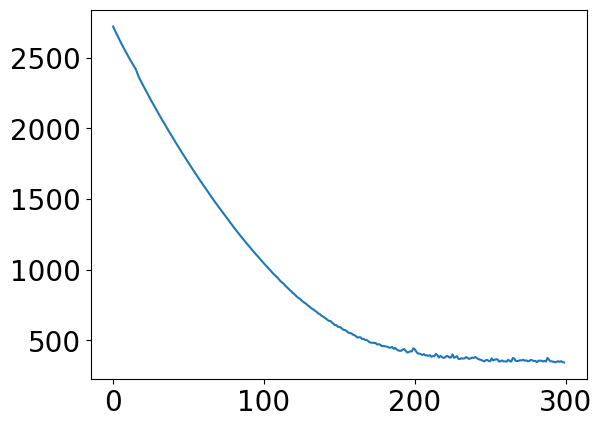

In [26]:
nn_model = do_nn_exp()

In [7]:
# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

# TS with linear conclusion
tsl_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)

start_time = time.time()
tsl_model.fit(x_train, y_train)
time_used = time.time() - start_time

FCM training RMSE: 269.5596057487083


In [8]:
# TS model
# Constant conclusion


tsc_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)

start_time = time.time()
tsc_model.fit(x_train, y_train)
time_used = time.time() - start_time

(2207, 150)
[[2.48875363e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.28078458e-16 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.58695968e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.79521141e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.96038604e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22184768e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2207, 25)
[[2.48875363e-09 9.95890496e-11 1.71494769e-09 ... 1.83873268e-11
  9.99690977e-01 4.54981202e-10]
 [5.28078458e-16 2.76686871e-17 3.50741785e-15 ... 4.52959808e-18
  1.03902297e-10 6.05327611e-16]
 [2.58695968e-08 8.90924374e-09 1.58169400e-08 ... 4.07632875e-10
  2.46174377e-06 5.24244467e-09]
 ...
 [9.79521141e-01 9.72796035e-07 9.62941491e-07 ... 2.49340353e-07
  1.62918

In [9]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

# From ts linear
for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    indices = np.random.choice(x_train.shape[0], 2000, replace=False)        

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

GP Train RMSE: 562.127 ± 352.531
GP Test RMSE: 1739.661 ± 1125.231
GP R2: 0.039 ± 0.761
GP Time: 33.007 ± 50.083


In [10]:
# GPR model
gp_tsl_train_accuracy = []
gp_tsl_test_accuracy = []
gp_tsl_r2s = []
gp_tsl_time = []
gpr_tsl_model = None

# From ts linear
for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)

    start_time = time.time()
    gpr_tsl_model.fit(tsl_model.cen, ts_relu_wrapper(tsl_model.predict(tsl_model.cen + 1e-8)))
    time_used = time.time() - start_time

    train_means = gpr_tsl_model.predict(x_train)
    test_means = gpr_tsl_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_tsl_train_accuracy.append(train_rmse)
    gp_tsl_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_tsl_r2s.append(gp_r2)
    gp_tsl_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_tsl_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_tsl_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_tsl_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_tsl_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_tsl_r2s),3)
gp_r2_std = np.round(np.std(gp_tsl_r2s),3)
gp_time_mean = np.round(np.mean(gp_tsl_time),3)
gp_time_std = np.round(np.std(gp_tsl_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

GP Train RMSE: 399.168 ± 0.0
GP Test RMSE: 379.511 ± 0.0
GP R2: 0.968 ± 0.0
GP Time: 0.03 ± 0.01


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

In [11]:
# GPR model
gp_tsc_train_accuracy = []
gp_tsc_test_accuracy = []
gp_tsc_r2s = []
gp_tsc_time = []
gpr_tsc_model = None

# From ts constant
for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_tsc_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)

    start_time = time.time()
    gpr_tsc_model.fit(tsc_model.cen, ts_relu_wrapper(tsc_model.predict(tsc_model.cen + 1e-8)))
    time_used = time.time() - start_time

    train_means = gpr_tsc_model.predict(x_train)
    test_means = gpr_tsc_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_tsc_train_accuracy.append(train_rmse)
    gp_tsc_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_tsc_r2s.append(gp_r2)
    gp_tsc_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_tsc_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_tsc_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_tsc_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_tsc_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_tsc_r2s),3)
gp_r2_std = np.round(np.std(gp_tsc_r2s),3)
gp_time_mean = np.round(np.mean(gp_tsc_time),3)
gp_time_std = np.round(np.std(gp_tsc_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

GP Train RMSE: 387.903 ± 0.0
GP Test RMSE: 365.297 ± 0.0
GP R2: 0.97 ± 0.0
GP Time: 0.028 ± 0.011


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [27]:
# GPR model
gp_nn_tsl_train_accuracy = []
gp_nn_tsl_test_accuracy = []
gp_nn_tsl_r2s = []
nn_tsl_r2s = []
gp_nn_tsl_time = []
gpr_nn_tsl_model = None

# From NN and ts linear
for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_nn_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)

    start_time = time.time()
    inputs = tsl_model.cen
    ts_predictions = ts_relu_wrapper(tsl_model.predict(tsl_model.cen + 1e-8))
    nn_predictions = nn_model.predict(inputs)
    gpr_nn_tsl_model.fit(inputs, nn_predictions)
    time_used = time.time() - start_time

    train_means = gpr_nn_tsl_model.predict(x_train)
    test_means = gpr_nn_tsl_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_nn_tsl_train_accuracy.append(train_rmse)
    gp_nn_tsl_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_nn_tsl_r2s.append(gp_r2)
    gp_nn_tsl_time.append(time_used)
    nn_tsl_r2s.append(r2_score(ts_predictions, nn_predictions))

gp_train_accuracy_mean = np.round(np.mean(gp_nn_tsl_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_nn_tsl_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_nn_tsl_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_nn_tsl_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_nn_tsl_r2s),3)
gp_r2_std = np.round(np.std(gp_nn_tsl_r2s),3)
gp_time_mean = np.round(np.mean(gp_nn_tsl_time),3)
gp_time_std = np.round(np.std(gp_nn_tsl_time),3)
nn_ts_r2_mean = np.round(np.mean(nn_tsl_r2s),3)
nn_ts_r2_std = np.round(np.std(nn_tsl_r2s),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")
print(f"TS NN R2: {nn_ts_r2_mean} ± {nn_ts_r2_std}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
GP Train RMSE: 465.925 ± 0.0
GP Test RMSE: 442.991 ± 0.0
GP R2: 0.956 ± 0.0
GP Time: 0.032 ± 0.011
TS NN R2: 0.993 ± 0.0


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
# GPR model
gp_nn_tsc_train_accuracy = []
gp_nn_tsc_test_accuracy = []
gp_nn_tsc_r2s = []
nn_tsc_r2s = []
gp_nn_tsc_time = []
gpr_nn_tsc_model = None

# From NN and ts constant
for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_nn_tsc_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)

    start_time = time.time()
    inputs = tsc_model.cen
    ts_predictions = tsc_model.predict(tsc_model.cen + 1e-8)
    nn_predictions = nn_model.predict(inputs)
    gpr_nn_tsc_model.fit(inputs, nn_predictions)
    time_used = time.time() - start_time

    train_means = gpr_nn_tsc_model.predict(x_train)
    test_means = gpr_nn_tsc_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_nn_tsc_train_accuracy.append(train_rmse)
    gp_nn_tsc_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_nn_tsc_r2s.append(gp_r2)
    gp_nn_tsc_time.append(time_used)
    nn_tsc_r2s.append(r2_score(ts_predictions, nn_predictions))

gp_train_accuracy_mean = np.round(np.mean(gp_nn_tsc_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_nn_tsc_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_nn_tsc_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_nn_tsc_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_nn_tsc_r2s),3)
gp_r2_std = np.round(np.std(gp_nn_tsc_r2s),3)
gp_time_mean = np.round(np.mean(gp_nn_tsc_time),3)
gp_time_std = np.round(np.std(gp_nn_tsc_time),3)
nn_ts_r2_mean = np.round(np.mean(nn_tsc_r2s),3)
nn_ts_r2_std = np.round(np.std(nn_tsc_r2s),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")
print(f"TS NN R2: {nn_ts_r2_mean} ± {nn_ts_r2_std}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Train RMSE: 446.769 ± 0.0
GP Test RMSE: 420.203 ± 0.0
GP R2: 0.96 ± 0.0
GP Time: 0.036 ± 0.008
TS NN R2: 0.993 ± 0.0


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
